# Rotation estimation

In [1]:
import json
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import random

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import Input
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D, LeakyReLU

In [101]:
DATADIR = "dataset_generator/images/rotation2/"
JSON_file_name = "data.txt"
IMAGES = 2_000
OG_IMG_SIZE = 800
IMG_SIZE = 100

In [102]:
data_json = []
for line in open(DATADIR + JSON_file_name, 'r'):
    data_json.append(json.loads(line))
    
dataset = [] # [x, y]

for img in os.listdir(DATADIR):
    if(img.endswith(".jpg")):
        img_array = cv2.imread(os.path.join(DATADIR, img), cv2.IMREAD_GRAYSCALE)
        img_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))

        img_index = int(img.strip(".jpg"))
        for label in data_json:
            if(label['index'] == img_index):
                choosen_label = {'rotX': label['rotX'], 'rotY': label['rotY']}
                
                xy = [img_array, choosen_label]
                dataset.append(xy)
                
        if(len(dataset)%500 ==0):
            print(f"{len(dataset)} images loaded")
        
        if(len(dataset) >= IMAGES):
            print("All images loaded")
            break
            
IMAGES = len(dataset)
print(f"{IMAGES} in total")

500 images loaded
1000 images loaded
1500 images loaded
2000 images loaded
All images loaded
2000 in total


X shape: (2000, 100, 100, 1)
y shape: (2000, 2)


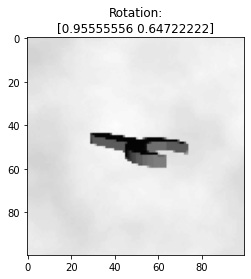

In [109]:
X = []
y = []

shuffled_indices = random.sample(range(0, IMAGES), IMAGES)

for i in shuffled_indices:
    X.append(dataset[i][0])
    
    y_labels = [dataset[i][1]['rotX']/360, dataset[i][1]['rotY']/360]

    y.append(y_labels)

# Global Standardization
X = (np.array(X).reshape(IMAGES, IMG_SIZE, IMG_SIZE, 1) - np.mean(X)) / np.std(X)
y = np.array(y)

print(f"X shape: {X.shape}\ny shape: {y.shape}")

random_index = random.randrange(IMAGES)

plt.title(f"Rotation:\n{y[random_index]}")
plt.imshow(X[random_index], cmap="gray")
plt.show()

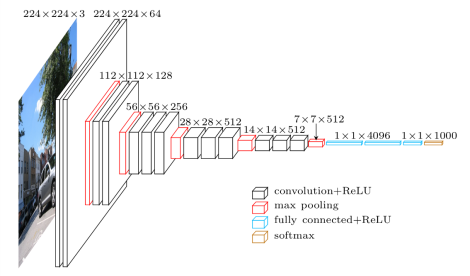
https://www.pyimagesearch.com/2017/03/20/imagenet-vggnet-resnet-inception-xception-keras<br>
https://arxiv.org/pdf/1409.1556.pdf

In [110]:
inputs = Input(name="inputs",
              shape = (IMG_SIZE, IMG_SIZE, 1))

rotationStream = Conv2D(name = "conv_1",
                       filters = 16,
                       kernel_size = 7, 
                       strides = 1,
                       padding = "same",
                       kernel_initializer=tf.keras.initializers.GlorotUniform())(inputs)

rotationStream = MaxPooling2D(name = "maxPool_1",
                             pool_size = (2, 2))(rotationStream)

rotationStream = Conv2D(name = "conv_2",
                       filters = 16,
                       kernel_size = 5, 
                       strides = 1,
                       padding = "same",
                       kernel_initializer=tf.keras.initializers.GlorotUniform())(rotationStream)

rotationStream = MaxPooling2D(name = "maxPool_2",
                             pool_size = (2, 2))(rotationStream)

rotationStream = Flatten()(rotationStream)

rotationStream = Dense(10, activation="relu")(rotationStream)
rotationStream = Dense(10, activation="relu")(rotationStream)

rotationStream = Dense(2, name = "output")(rotationStream)

model = keras.Model(inputs, rotationStream, name = "Rotation_CNN")
# model_optimizer = tf.keras.optimizers.Adam(
#     learning_rate=0.001,
#     beta_1=0.9,
#     amsgrad=False)

model_optimizer = tf.keras.optimizers.SGD()

model_loss = tf.keras.losses.MeanSquaredError()

model.compile(optimizer = model_optimizer,
              loss = model_loss) 

model.summary()

Model: "Rotation_CNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          [(None, 100, 100, 1)]     0         
_________________________________________________________________
conv_1 (Conv2D)              (None, 100, 100, 16)      800       
_________________________________________________________________
maxPool_1 (MaxPooling2D)     (None, 50, 50, 16)        0         
_________________________________________________________________
conv_2 (Conv2D)              (None, 50, 50, 16)        6416      
_________________________________________________________________
maxPool_2 (MaxPooling2D)     (None, 25, 25, 16)        0         
_________________________________________________________________
flatten_14 (Flatten)         (None, 10000)             0         
_________________________________________________________________
dense_29 (Dense)             (None, 10)               

In [111]:
history = model.fit(x = X,
                    y = y, 
                    batch_size=32, 
                    epochs=10, 
                    validation_split=0.2)

Epoch 1/10
50/50 [==============================] - 4s 87ms/step - loss: 0.2702 - val_loss: 0.0378
Epoch 2/10
50/50 [==============================] - 4s 84ms/step - loss: 0.0307 - val_loss: 0.0278
Epoch 3/10
50/50 [==============================] - 4s 85ms/step - loss: 0.0228 - val_loss: 0.0213
Epoch 4/10
50/50 [==============================] - 4s 84ms/step - loss: 0.0183 - val_loss: 0.0175
Epoch 5/10
50/50 [==============================] - 4s 85ms/step - loss: 0.0156 - val_loss: 0.0208
Epoch 6/10
50/50 [==============================] - 4s 84ms/step - loss: 0.0131 - val_loss: 0.0130
Epoch 7/10
50/50 [==============================] - 4s 85ms/step - loss: 0.0112 - val_loss: 0.0112
Epoch 8/10
50/50 [==============================] - 4s 85ms/step - loss: 0.0097 - val_loss: 0.0099
Epoch 9/10
50/50 [==============================] - 4s 85ms/step - loss: 0.0088 - val_loss: 0.0096
Epoch 10/10
50/50 [==============================] - 4s 85ms/step - loss: 0.0081 - val_loss: 0.0088


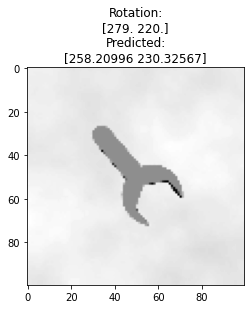

In [118]:
random_index = random.randrange(IMAGES)
prediction = model.predict(X[random_index].reshape(1, 100, 100, 1))

plt.title(f"Rotation:\n{y[random_index]*360}\nPredicted:\n{prediction[0]*360}")
plt.imshow(X[random_index], cmap="gray")
plt.show()